<a href="https://colab.research.google.com/github/techandy42/Codegen_Challenge_Submission/blob/main/codegen_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/codegen-sh/Loop-Labyrinth-Analysis.git

Cloning into 'Loop-Labyrinth-Analysis'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 2), reused 26 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 4.31 KiB | 4.31 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
!git clone https://github.com/helloflask/flask-examples.git

Cloning into 'flask-examples'...
remote: Enumerating objects: 638, done.
remote: Total 638 (delta 0), reused 0 (delta 0), pack-reused 638 (from 1)
Receiving objects: 100% (638/638), 1.85 MiB | 2.79 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [4]:
DIRECTORY_PATH = "/content/Loop-Labyrinth-Analysis"

In [5]:
import os

def list_python_files(parent_dir):
    python_files = []
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if file.endswith('.py'):
                # Get relative path
                relative_path = os.path.relpath(os.path.join(root, file), parent_dir)
                python_files.append(relative_path)
    return python_files

# Example Usage
parent_directory = DIRECTORY_PATH  # Replace with your directory path
py_files = list_python_files(parent_directory)
for file in py_files:
    print(file)

app.py
services/user_service.py
services/order_service.py
services/auth_service.py
services/session_service.py
services/product_service.py
controllers/product_controller.py
controllers/auth_controller.py
controllers/user_controller.py
utils/auth_utils.py
utils/common.py
utils/another_util.py
models/user.py
models/product.py
models/order.py


In [11]:
!pip install stdlib-list

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.3 MB/s eta 0:00:00


In [21]:
import ast
import os
import sys
from pathlib import Path
from typing import List, Tuple, Set, Dict
import pkgutil
from stdlib_list import stdlib_list
from collections import defaultdict

def analyze_imports_in_file(root_dir: str, target_file_rel_path: str) -> List[Tuple[str, List[str], str]]:
    """
    Analyze import statements in a specified Python file, extracting modules and their imported symbols,
    and categorize each module as 'internal', 'standard library', 'external (installed package)', or 'unknown'.

    Parameters:
    - root_dir (str): Absolute path to the root directory of the codebase.
    - target_file_rel_path (str): Relative path to the target Python file from the root directory.

    Returns:
    - List[Tuple[str, List[str], str]]: A list of tuples where each tuple contains:
        - module_name (str): The full import path of the imported module (e.g., 'flask', 'controllers.user_controller').
        - symbols (List[str]): A list of symbols imported from the module. Empty if no specific symbols are imported.
        - module_type (str): The category of the module ('internal', 'standard library', 'external (installed package)', 'unknown').
    """

    def extract_imports_with_symbols(file_path: str) -> List[Tuple[str, List[str]]]:
        """
        Extract import statements from a Python file, including imported symbols.

        Parameters:
        - file_path (str): Absolute path to the Python file.

        Returns:
        - List[Tuple[str, List[str]]]: A list of tuples where each tuple contains:
            - module_name (str): The full import path of the imported module.
            - symbols (List[str]): A list of symbols imported from the module.
        """
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                node = ast.parse(file.read(), filename=file_path)
        except (FileNotFoundError, SyntaxError) as e:
            print(f"Error parsing {file_path}: {e}")
            return []

        imports = []

        for stmt in ast.walk(node):
            if isinstance(stmt, ast.Import):
                for alias in stmt.names:
                    if alias.name:
                        # 'import module' -> symbols list is empty
                        imports.append((alias.name, []))
            elif isinstance(stmt, ast.ImportFrom):
                if stmt.module:
                    # Handle relative imports by prefixing dots
                    module_name = '.' * stmt.level + stmt.module
                else:
                    module_name = '.' * stmt.level
                if module_name:
                    # Extract imported symbols
                    symbols = [alias.name for alias in stmt.names if alias.name]
                    imports.append((module_name, symbols))

        # Resolve relative imports to absolute imports based on the target file's location
        absolute_imports = []
        for imp, symbols in imports:
            if imp.startswith('.'):
                # Count the number of leading dots
                level = len(imp) - len(imp.lstrip('.'))
                relative_module = imp.lstrip('.')
                # Get the directory of the target file
                target_dir = os.path.dirname(os.path.join(root_dir, target_file_rel_path))
                # Convert target_dir to module path
                if target_dir == root_dir:
                    base_module = ''
                else:
                    relative_path = os.path.relpath(target_dir, root_dir)
                    base_module = relative_path.replace(os.sep, '.')
                # Adjust based on the level
                if level > 0:
                    base_parts = base_module.split('.') if base_module else []
                    if level > len(base_parts):
                        # Relative import goes beyond the top-level package
                        resolved_module = relative_module  # Unable to resolve, keep as is
                    else:
                        resolved_base = '.'.join(base_parts[:-level + 1]) if level > 1 else base_module
                        resolved_module = f"{resolved_base}.{relative_module}" if relative_module else resolved_base
                else:
                    resolved_module = relative_module
                resolved_module = resolved_module.strip('.')
                if resolved_module:
                    absolute_imports.append((resolved_module, symbols))
            else:
                absolute_imports.append((imp, symbols))

        return absolute_imports

    def get_all_internal_modules(parent_dir: str) -> Set[str]:
        """
        Traverse the parent directory to list all internal modules based on the full import paths.

        Parameters:
        - parent_dir (str): Absolute path to the root directory of the codebase.

        Returns:
        - Set[str]: A set of internal module full import paths.
        """
        internal_modules = set()
        for root, dirs, files in os.walk(parent_dir):
            # Compute the relative path from root_dir
            rel_dir = os.path.relpath(root, parent_dir)
            if rel_dir == '.':
                rel_dir = ''
            else:
                rel_dir = rel_dir.replace(os.sep, '.')

            # Check for packages (__init__.py)
            if '__init__.py' in files:
                if rel_dir:
                    internal_modules.add(rel_dir)

            # Check for standalone .py files
            for file in files:
                if file.endswith('.py'):
                    if file == '__init__.py':
                        continue  # Already handled as package
                    module_name = file[:-3]  # Remove .py extension
                    if rel_dir:
                        full_module = f"{rel_dir}.{module_name}"
                    else:
                        full_module = module_name
                    internal_modules.add(full_module)
        return internal_modules

    def get_standard_lib_modules() -> Set[str]:
        """
        Retrieve a set of all standard library modules for the current Python version.

        Returns:
        - Set[str]: A set containing the names of standard library modules.
        """
        version = f"{sys.version_info.major}.{sys.version_info.minor}"
        return set(stdlib_list(version))

    def get_installed_packages() -> Set[str]:
        """
        Retrieve a set of all installed packages in the current environment.

        Returns:
        - Set[str]: A set containing the names of installed packages.
        """
        return {module.name for module in pkgutil.iter_modules()}

    # Resolve absolute path to the target file
    target_file_path = os.path.join(root_dir, target_file_rel_path)

    if not os.path.isfile(target_file_path):
        raise FileNotFoundError(f"The file '{target_file_rel_path}' does not exist in '{root_dir}'.")

    # Precompute internal modules
    internal_modules = get_all_internal_modules(root_dir)

    # Get installed packages
    installed_packages = get_installed_packages()

    # Get standard library modules
    stdlib_modules = get_standard_lib_modules()

    # Extract imports with symbols from the target file
    imports_with_symbols = extract_imports_with_symbols(target_file_path)

    # Merge symbols from the same module
    merged_imports: Dict[str, List[str]] = defaultdict(list)
    for module, symbols in imports_with_symbols:
        merged_imports[module].extend(symbols)

    # Remove duplicate symbols for each module
    for module in merged_imports:
        merged_imports[module] = list(set(merged_imports[module]))

    # Prepare the final list of tuples
    final_imports: List[Tuple[str, List[str], str]] = []
    for module, symbols in merged_imports.items():
        # Determine module type
        if module in internal_modules:
            module_type = 'internal'
        elif module in stdlib_modules:
            module_type = 'standard library'
        elif module in installed_packages:
            module_type = 'external (installed package)'
        else:
            module_type = 'unknown'
        final_imports.append((module, symbols, module_type))

    return final_imports

In [23]:
analyze_imports_in_file(DIRECTORY_PATH, list_python_files(parent_directory)[0])

[('flask', ['Flask1', 'Flask3', 'Flask2'], 'external (installed package)'),
 ('controllers.user_controller', ['user_routes'], 'internal')]

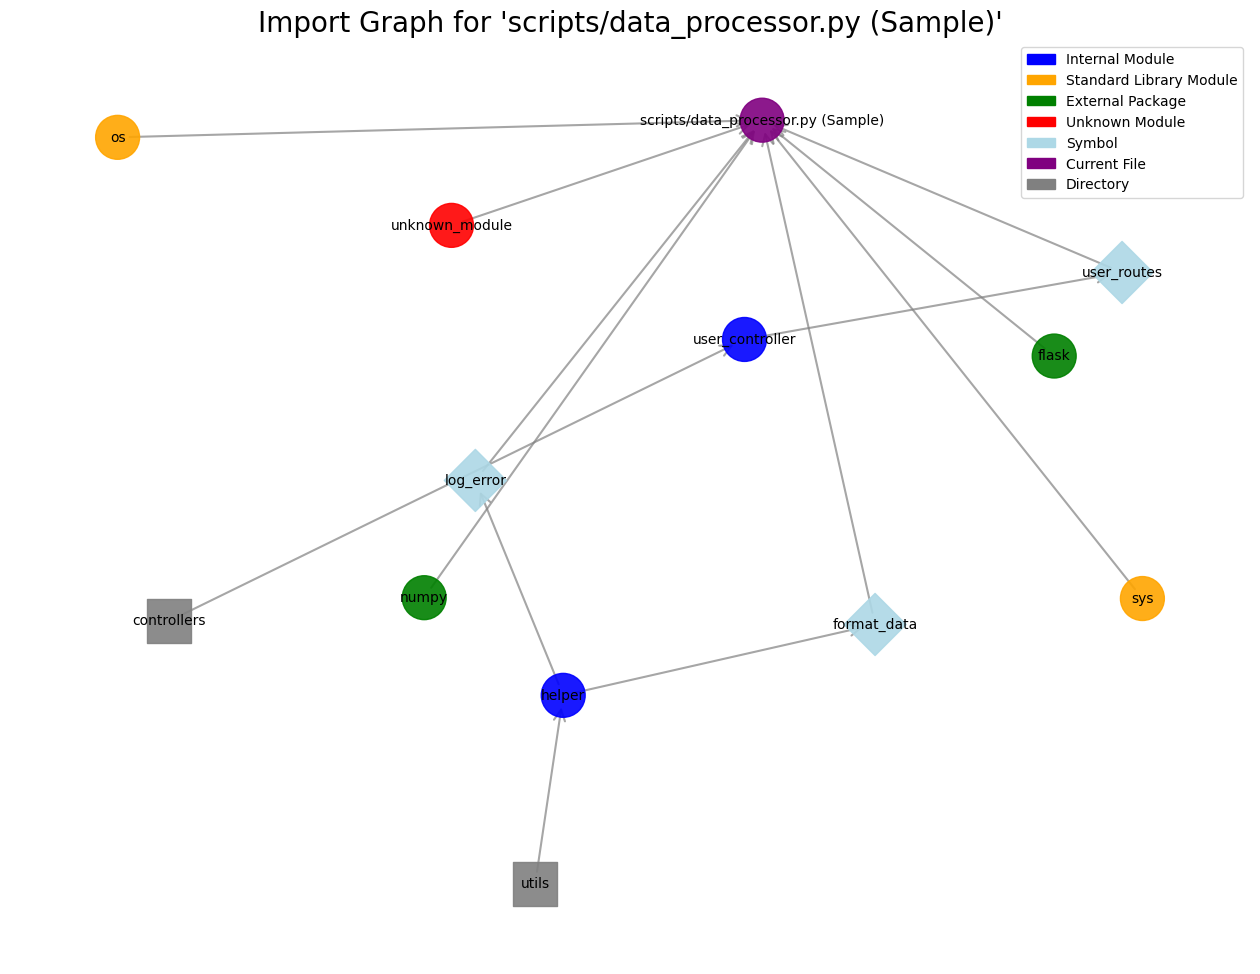

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple
from collections import defaultdict

def generate_import_graph(current_file: str, imports: List[Tuple[str, List[str], str]], visualize: bool = False) -> nx.DiGraph:
    """
    Generates a NetworkX directed graph mapping the imported modules and their symbols of a Python file with hierarchical representation.

    Parameters:
    - current_file (str): The relative path of the current Python file (e.g., 'scripts/data_processor.py').
    - imports (List[Tuple[str, List[str], str]]): A list of tuples where each tuple contains:
        - module_name (str): The full import path of the imported module (e.g., 'flask', 'controllers.user_controller').
        - symbols (List[str]): A list of symbols imported from the module.
        - module_type (str): The category of the module ('internal', 'standard library', 'external (installed package)', 'unknown').
    - visualize (bool): If True, displays a visual representation of the graph using Matplotlib.

    Returns:
    - G (nx.DiGraph): A NetworkX directed graph object representing the import relationships.
    """

    # Initialize a directed graph
    G = nx.DiGraph()

    # Add the current file as the central node with specific attributes
    G.add_node(current_file, type='current_file', shape='o', color='purple')  # 'o' for circle

    # Define a mapping from module_type to colors for visualization
    type_color_mapping = {
        'internal': 'blue',
        'standard library': 'orange',
        'external (installed package)': 'green',
        'unknown': 'red',
        'current_file': 'purple'  # Color for the central node
    }

    # Define a mapping for node shapes
    shape_mapping = {
        'directory': 's',    # Square
        'module': 'o',       # Circle
        'symbol': 'D',       # Diamond
        'current_file': 'o'  # Circle
    }

    # Helper function to add directory and module nodes
    def add_module_nodes(module_name: str, module_type: str):
        """
        Breaks down a module name into directories and module/file, adds nodes and edges to the graph.

        Parameters:
        - module_name (str): Full import path of the module (e.g., 'controllers.user_controller').
        - module_type (str): Type of the module ('internal', 'standard library', 'external (installed package)', 'unknown').
        """
        parts = module_name.split('.')
        parent = None
        cumulative_path = ""

        for index, part in enumerate(parts):
            if cumulative_path:
                cumulative_path += f".{part}"
            else:
                cumulative_path = part

            # Determine if the node is a directory or a module/file
            if index < len(parts) - 1:
                node_type = 'directory'
                shape = shape_mapping['directory']
                # Directories can have a neutral color or based on internal/external
                color = 'grey'
            else:
                node_type = 'module'
                shape = shape_mapping['module']
                color = type_color_mapping.get(module_type, 'grey')

            # Add the node if it doesn't exist
            if not G.has_node(cumulative_path):
                G.add_node(cumulative_path, type=node_type, shape=shape, color=color)

            # If there's a parent, add an edge from parent to current node
            if parent:
                G.add_edge(parent, cumulative_path)

            # Set current node as parent for next iteration
            parent = cumulative_path

    # Helper function to add symbol nodes
    def add_symbol_nodes(module_name: str, symbols: List[str]):
        """
        Adds symbol nodes connected to the specified module.

        Parameters:
        - module_name (str): Full import path of the module (e.g., 'controllers.user_controller').
        - symbols (List[str]): List of symbols imported from the module.
        """
        for symbol in symbols:
            symbol_node = f"{module_name}.{symbol}"
            # Add symbol node with attributes
            G.add_node(symbol_node, type='symbol', shape=shape_mapping['symbol'], color='lightblue')
            # Add edge from module to symbol
            G.add_edge(module_name, symbol_node)
            # Add edge from symbol to current file
            G.add_edge(symbol_node, current_file)

    # Process each import
    for module_name, symbols, module_type in imports:
        # Add directory and module nodes
        add_module_nodes(module_name, module_type)
        # Add symbols and connect to current file
        if symbols:
            add_symbol_nodes(module_name, symbols)
        else:
            # If no symbols are imported, connect module directly to current file
            G.add_edge(module_name, current_file)

    if visualize:
        # Set the size of the plot
        plt.figure(figsize=(16, 12))

        # Position nodes using the spring layout for better visualization
        pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

        # Extract node colors and shapes
        node_colors = [G.nodes[node]['color'] for node in G.nodes()]
        node_shapes = [G.nodes[node]['shape'] for node in G.nodes()]

        # Create a mapping from shape to list of nodes
        shape_to_nodes = defaultdict(list)
        for node, shape in zip(G.nodes(), node_shapes):
            shape_to_nodes[shape].append(node)

        # Draw nodes with different shapes
        for shape, nodes in shape_to_nodes.items():
            nx.draw_networkx_nodes(
                G, pos,
                nodelist=nodes,
                node_shape=shape,
                node_color=[G.nodes[n]['color'] for n in nodes],
                node_size=1000,
                alpha=0.9,
                label=shape_mapping_inverse(shape)
            )

        # Draw the edges
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray', width=1.5, alpha=0.7)

        # Prepare labels (show only the last part for clarity)
        labels = {}
        for node in G.nodes():
            if node == current_file:
                labels[node] = node
            else:
                labels[node] = node.split('.')[-1]
        nx.draw_networkx_labels(G, pos, labels, font_size=10, font_family="sans-serif")

        # Create legend for node types
        from matplotlib.patches import Patch
        from matplotlib.lines import Line2D

        # Legend for module types
        type_legend_elements = [
            Patch(facecolor='blue', edgecolor='blue', label='Internal Module'),
            Patch(facecolor='orange', edgecolor='orange', label='Standard Library Module'),
            Patch(facecolor='green', edgecolor='green', label='External Package'),
            Patch(facecolor='red', edgecolor='red', label='Unknown Module'),
            Patch(facecolor='lightblue', edgecolor='lightblue', label='Symbol'),
            Patch(facecolor='purple', edgecolor='purple', label='Current File'),
            Patch(facecolor='grey', edgecolor='grey', label='Directory')
        ]

        # Add legends to the plot
        plt.legend(handles=type_legend_elements, loc='upper right')

        # Remove axis
        plt.axis('off')

        # Add title
        plt.title(f"Import Graph for '{current_file}'", fontsize=20)

        # Display the graph
        plt.show()

    return G

def shape_mapping_inverse(shape_code: str) -> str:
    """
    Returns a descriptive label based on the shape code.

    Parameters:
    - shape_code (str): The matplotlib shape code.

    Returns:
    - str: Descriptive label for the shape.
    """
    mapping = {
        's': 'Directory',
        'o': 'Module/File',
        'D': 'Symbol'
    }
    return mapping.get(shape_code, 'Unknown Shape')

# Example Usage
if __name__ == "__main__":
    # Define the relative path of the current Python file
    current_file_rel_path = 'scripts/data_processor.py (Sample)'

    # Define the list of imported modules with their symbols and types
    imported_modules = [
        ('flask', [], 'external (installed package)'),
        ('controllers.user_controller', ['user_routes'], 'internal'),
        ('os', [], 'standard library'),
        ('sys', [], 'standard library'),
        ('numpy', [], 'external (installed package)'),
        ('utils.helper', ['format_data', 'log_error'], 'internal'),
        ('unknown_module', [], 'unknown')
    ]

    # Generate and visualize the import graph
    graph = generate_import_graph(current_file_rel_path, imported_modules, visualize=True)

In [27]:
FILE_NO = 0 # Change this value to visualize different files
file_path = list_python_files(parent_directory)[FILE_NO]
imports = analyze_imports_in_file(DIRECTORY_PATH, file_path)

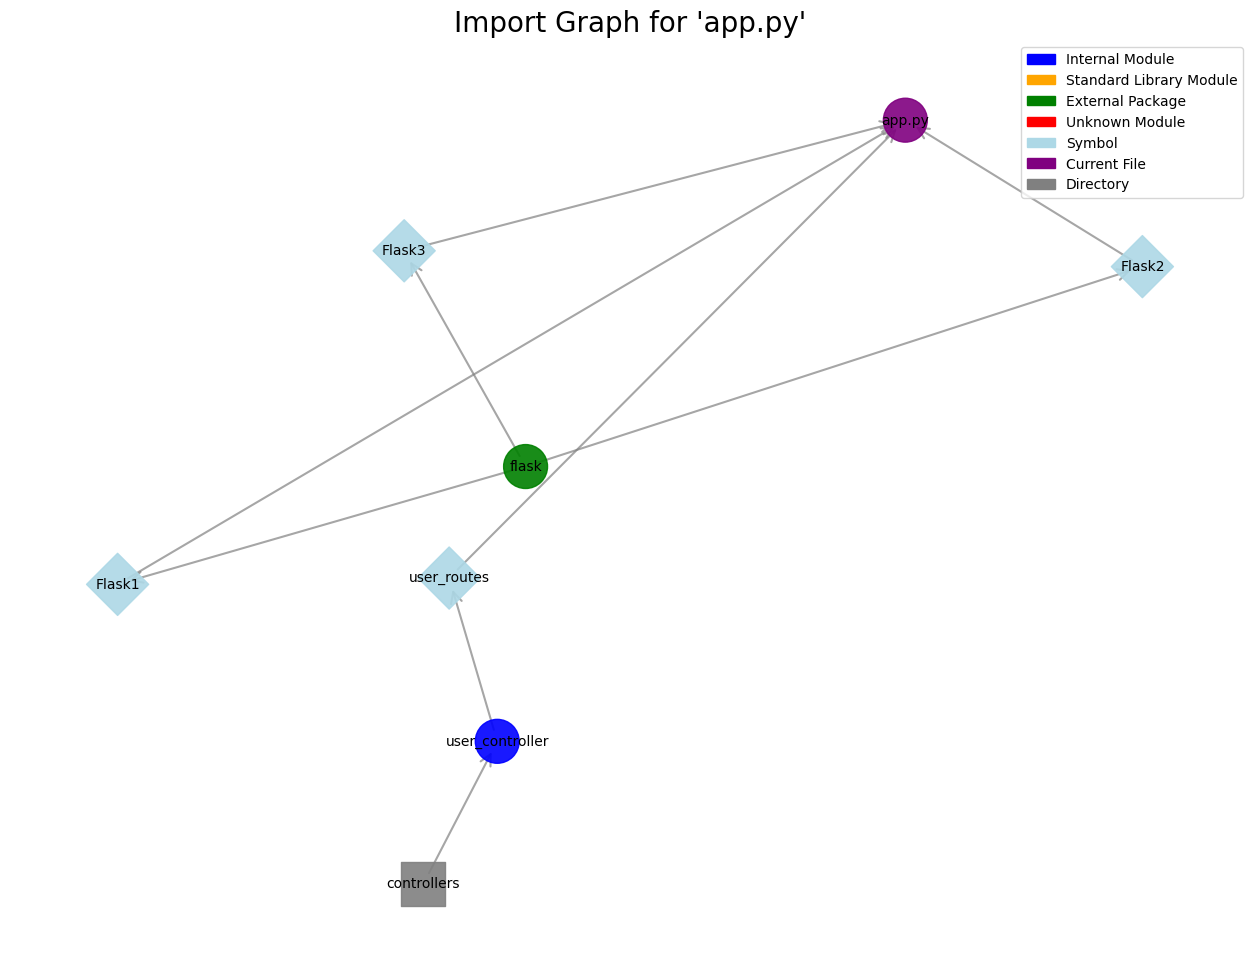

In [28]:
graph = generate_import_graph(file_path, imports, visualize=True)